##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для генерации обучающих данных. Папка dataset содержит сырые изображения, необходимо конвертировать их в numpy-массив для более удобной загрузки данных. Также в этом блокноте при помощи простого алгоритма создаются синтетические изображения, которые также конвертируются в numpy-массивы. Таким образом, в дальнейшем в файлах с обучением моделей достаточно просто обратно подгрузить эти данные.

**Подключение данных из гитхаб-репозитория**

In [1]:
!git clone https://github.com/villerbond/nytrogen-status-analysis

Cloning into 'nytrogen-status-analysis'...
remote: Enumerating objects: 580, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (577/577), done.
remote: Total 580 (delta 14), reused 554 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (580/580), 11.09 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (14/14), done.


**Подключение гугл-диска, чтобы загрузить туда данные в виде сжатых numpy-массивов (и исходные, и синтетические)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Подключение всех необходимых библиотек**

In [11]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

**Создание массивов путей до изображений**

In [4]:
train_dataset_dir = 'nytrogen-status-analysis/dataset/raw/train/'
test_dataset_dir = 'nytrogen-status-analysis/dataset/raw/test/'

In [5]:
def collect_data(root_dir):
  """
    Собирает пути к изображениям и маскам из указанной директории.

    Аргументы:
    root_dir - корневая папка, содержащая спектральные изображения и маски.

    Возвращает:
    images - список словарей, где ключи — спектральные каналы ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям
    masks - список путей к файлам масок.
  """
  images = []  # Список для хранения словарей с путями к изображениям в разных каналах
  masks = []   # Список для хранения путей к маскам

  # Пути до папок с изображениями в разных каналах и с соответствующими масками
  spectra_dirs = ["NDVI", "NearIR", "RedEdge", "RGB"]
  spectra_paths = {spectrum: os.path.join(root_dir, spectrum) for spectrum in spectra_dirs}
  masks_dir = os.path.join(root_dir, "Mask")

  # Проверка существования папок
  for spectrum, path in spectra_paths.items():
    if not os.path.exists(path):
      raise FileNotFoundError(f"Папка с каналом {spectrum} не найдена: {path}")
  if not os.path.exists(masks_dir):
    raise FileNotFoundError(f"Папка с масками не найдена: {masks_dir}")

  # Получение списка файлов (изображений) из каждой папки
  mask_files = sorted(os.listdir(masks_dir))
  spectra_files = {spectrum: sorted(os.listdir(spectra_paths[spectrum])) for spectrum in spectra_dirs}

  # Добавление путей до изображений в массивы
  for i, mask_file in tqdm(enumerate(mask_files), total=len(mask_files), desc="Collecting"):
    entry = {}

    for spectrum in spectra_dirs:
      spectrum_path = spectra_paths[spectrum]
      spectrum_files_list = spectra_files[spectrum]
      if i < len(spectrum_files_list):
        entry[spectrum] = os.path.join(spectrum_path, spectrum_files_list[i])

    if entry:
      images.append(entry)
      masks.append(os.path.join(masks_dir, mask_file))

  return images, masks

In [6]:
train_images_paths, train_masks_paths = collect_data(train_dataset_dir)
test_images_paths, test_masks_paths = collect_data(test_dataset_dir)

print(f"\nРазмер тренировочного датасета: {len(train_images_paths)} изображений и {len(train_masks_paths)} масок")
print(f"Размер тестового датасета: {len(test_images_paths)} изображений и {len(test_masks_paths)} масок")

Collecting: 100%|██████████| 66/66 [00:00<00:00, 13112.17it/s]


Размер тренировочного датасета: 66 изображений и 66 масок
Размер тестового датасета: 66 изображений и 66 масок


**Проверка и визуализация изображений**

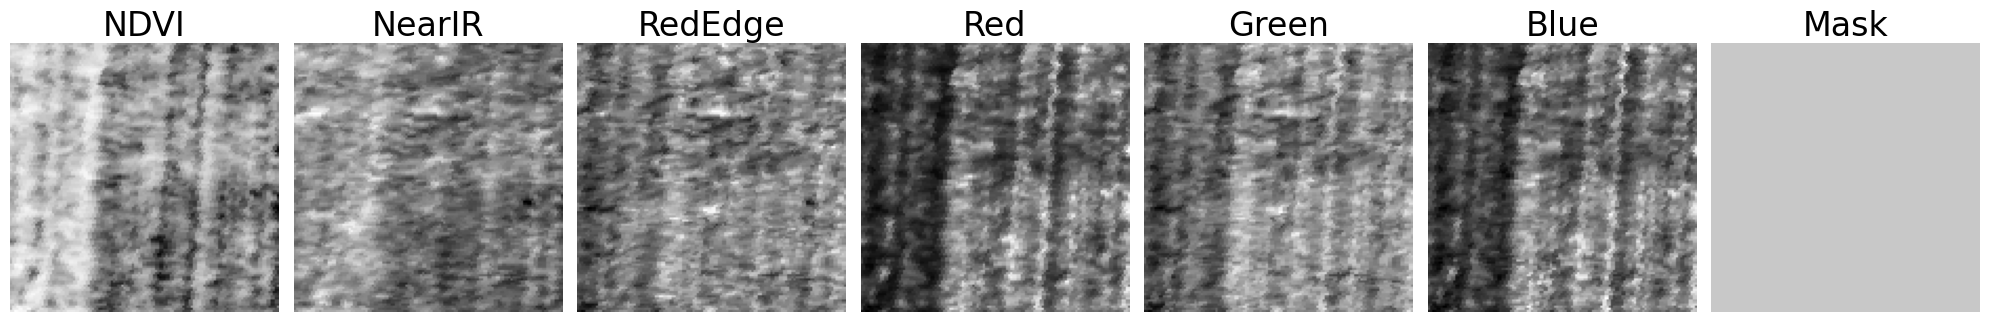

In [9]:
ind = random.randint(0, len(train_images_paths) - 1)
image_path = train_images_paths[ind]
mask_path = train_masks_paths[ind]

channels = {}
for spectrum, path in image_path.items():
  if spectrum == "RGB":
    rgb_image = Image.open(path)
    r, g, b = rgb_image.split()
    channels["Red"] = r
    channels["Green"] = g
    channels["Blue"] = b
  else:
    image = Image.open(path)
    channels[spectrum] = image

mask = Image.open(mask_path).convert("RGB")
num_spectra = len(channels)

fig, axes = plt.subplots(1, num_spectra + 1, figsize=(20, 5))
for i, (spectrum, image) in enumerate(channels.items()):
  axes[i].imshow(image, cmap="gray")
  axes[i].set_title(spectrum, fontsize=24)  # Увеличение размера шрифта
  axes[i].axis("Off")

axes[-1].imshow(mask, cmap="gray")
axes[-1].set_title("Mask", fontsize=24)  # Увеличение размера шрифта
axes[-1].axis("Off")

plt.tight_layout()
plt.show()

**Загрузка изображений в numpy-массивы**

In [12]:
def make_nparrays(images, masks):
    """
    Преобразует списки путей к изображениям и маскам в NumPy-массивы.

    Аргументы:
    images - список словарей, где ключи — спектральные диапазоны ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям.
    masks - список путей к файлам масок.

    Возвращает:
    X_data - массив изображений (количество каналов зависит от данных)
    y_data - массив сегментационных масок
    """

    X_data = []  # Массив изображений
    y_data = []  # Массив масок

    for image_paths, mask_path in tqdm(zip(images, masks), total=len(masks), desc='Processing data'):

        channels = []

        # Открываем и обрабатываем изображения разных спектров
        for spectrum, path in image_paths.items():
            img = Image.open(path)  # Загружаем изображение
            img = np.array(img) / 255.0  # Нормализуем значения пикселей в диапазон [0, 1]

            # Если канал не RGB, преобразуем его в формат (128, 128, 1), добавляя измерение глубины
            if spectrum != 'RGB':
                img = img.reshape((128, 128, 1))

            channels.append(img)  # Добавляем канал в список

        # Объединяем все спектральные каналы по последней оси (создаем многоканальное изображение)
        image = np.concatenate(channels, axis=-1)

        # Загружаем и обрабатываем маску
        mask = Image.open(mask_path)
        mask = np.array(mask)

        masks = [] # Список для хранения бинарных масок по классам

        # Разделяем маску на 6 классов по пороговым значениям
        for i in [0, 40, 80, 120, 160, 200]:
            cls_mask = (mask == i)  # Создаем бинарную маску для каждого класса
            masks.append(cls_mask)

        # Объединяем все бинарные маски в один массив (кол-во классов, H, W)
        masks = np.stack(masks, axis=0)

        # Преобразуем маску в формат (H, W, 1), где в каждом пикселе записан номер класса
        mask = np.argmax(masks, axis=0)
        mask = np.expand_dims(mask, axis=-1)

        # Добавляем обработанные данные в списки
        X_data.append(image)
        y_data.append(mask)

    # Преобразуем списки в NumPy-массивы
    return np.array(X_data), np.array(y_data, dtype=np.uint8)


In [13]:
train_images, train_masks = make_nparrays(train_images_paths, train_masks_paths)
test_images, test_masks = make_nparrays(test_images_paths, test_masks_paths)
print(f"\nРазмер массива тренировочных изображений: {train_images.shape}\nРазмер массива тренировочных масок: {train_masks.shape}")
print(f"Размер массива тестовых изображений: {test_images.shape}\nРазмер массива тестовых масок: {test_masks.shape}")

Processing data: 100%|██████████| 66/66 [00:00<00:00, 257.53it/s]



Размер массива тренировочных изображений: (66, 128, 128, 6)
Размер массива тренировочных масок: (66, 128, 128, 1)
Размер массива тестовых изображений: (66, 128, 128, 6)
Размер массива тестовых масок: (66, 128, 128, 1)


Размер: (N, H, W, C), где

N - количество изображений,

H x W - размер изображения в пикселах

C - количество каналов (для обычных изображений шесть, три на RGB и по одному для NearIR, NDVI, RedEdge; для масок только один канал с классами)

**Сохранение данных в формате .npz — сжатом формате NumPy, который позволяет хранить несколько массивов в одном файле**

In [ ]:
np.savez_compressed("drive/MyDrive/VKR/dataset/train_images_and_masks.npz", train_images=train_images, train_masks=train_masks)
np.savez_compressed("drive/MyDrive/VKR/dataset/test_images_and_masks.npz", test_images=test_images, test_masks=test_masks)

В дальнейшем мы будем скачивать эти данные с диска таким образом:

In [ ]:
# import gdown
# train_url = 'https://drive.google.com/uc?id=14Xocom0pPP63u6SlajVF24HDYxaMLSo5'
# test_url = 'https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT'
# train_path = "nytrogen-status-analysis/dataset/train_images_and_masks.npz"
# test_path = "nytrogen-status-analysis/dataset/test_images_and_masks.npz"
# gdown.download(train_url, train_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# train_data = np.load(train_path)
# test_data = np.load(test_path)
# train_images = train_data["train_images"]
# train_masks = train_data["train_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]

**Генерация синтетических данных**

In [ ]:
# Функция для генерации заданного числа синтетических изображений и масок
def generate_synthetic_data(images, masks, N):
    images = images.transpose(0, 3, 1, 2)  # Перестановка каналов
    n, num_channels, h, w = images.shape
    generated_images = []
    generated_masks = []

    for i in range(N):
        base_idx = random.randint(0, n - 1)
        base_image = images[base_idx].copy()
        base_mask = masks[base_idx].copy()
        base_mask = base_mask.squeeze(axis=-1)

        new_img = base_image.copy()
        new_mask = base_mask.copy()

        num_sources = random.randint(1, 6)
        source_inds = np.random.choice([i for i in range(n) if i != base_idx], size=num_sources, replace=False)

        for ind in source_inds:
            img = images[ind]
            mask = masks[ind]
            mask = mask.squeeze(axis=-1)

            spot_mask = np.zeros((h, w), dtype=np.uint8)

            for _ in range(random.randint(3, 8)):  # Количество пятен на изображение
                # Генерация случайного прямоугольника с более равномерным распределением
                rect_w = random.randint(w // 16, w // 4)
                rect_h = random.randint(h // 16, h // 4)

                # Смещение положения в любую часть изображения
                x1 = random.randint(0, w - rect_w)  # Левый верхний угол по ширине
                y1 = random.randint(0, h - rect_h)  # Левый верхний угол по высоте
                x2 = x1 + rect_w
                y2 = y1 + rect_h

                # Добавляем случайные неровности к углам
                shift_range = max(rect_w, rect_h) // 10
                points = np.array([
                    [x1 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)],
                    [x1 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)]
                ], dtype=np.int32)

                # Рисуем многоугольник
                cv2.fillPoly(spot_mask, [points], 1)

            # Размываем для мягких краев
            spot_mask = cv2.GaussianBlur(spot_mask.astype(np.float32), (11, 11), 3)
            spot_mask = (spot_mask > 0.2).astype(np.uint8)

            # Накладываем прямоугольники на изображение и маску
            for c in range(num_channels):
                new_img[c] = np.where(spot_mask, img[c], new_img[c])
                new_mask = np.where(spot_mask, mask, new_mask)

        generated_images.append(new_img)
        generated_masks.append(new_mask)

    return np.array(generated_images), np.array(generated_masks)

In [ ]:
N = 2000
synth_images, synth_masks = generate_synthetic_data(train_images, train_masks, N)
print(synth_images.shape, synth_masks.shape)

(2000, 6, 128, 128) (2000, 128, 128)


**Демонстрация синтетических изображений и масок**

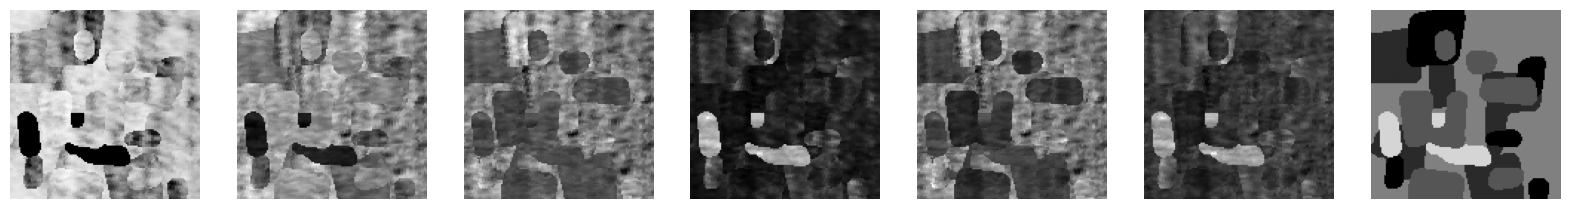

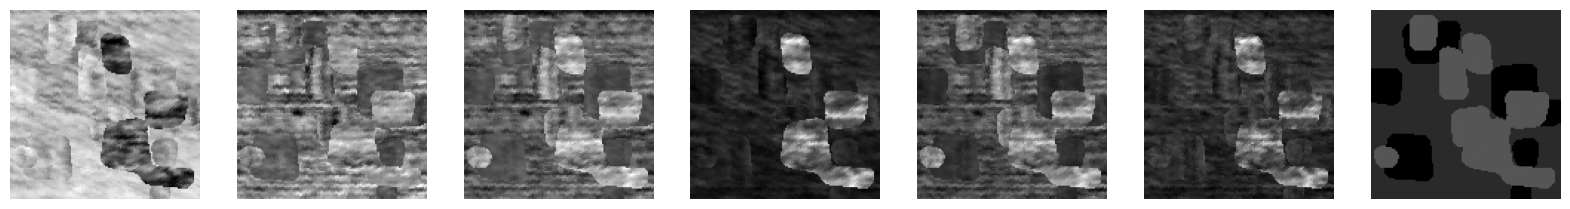

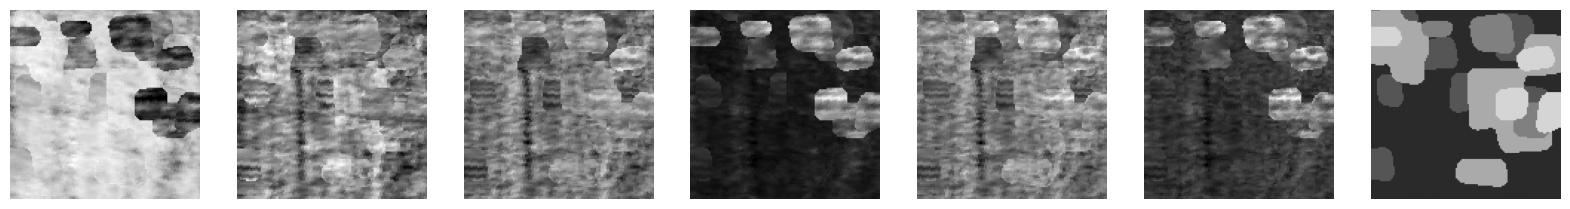

In [ ]:
for i in range(3):
  img = synth_images[i]
  mask = synth_masks[i]
  fig, ax = plt.subplots(1, 7, figsize=(20, 5))
  for i in range(6):
    ax[i].imshow(img[i], cmap='gray')
    ax[i].axis('Off')
  ax[-1].imshow(mask, cmap='gray', vmin=0, vmax=6)
  ax[-1].axis('Off')
  plt.show()

**Для создания сжатых данных преобразуем к нужному формату**

In [ ]:
# Преобразуем синтетические данные к формату (N, 128, 128, 6)
synth_images = np.transpose(synth_images, (0, 2, 3, 1))

# Преобразуем синтетические маски к формату (N, 128, 128, 1)
synth_masks = np.expand_dims(synth_masks, axis=-1)

# Проверяем итоговые размеры
print(f"Размер синтетических изображений: {synth_images.shape}")  # Должно быть (2000, 128, 128, 6)
print(f"Размер синтетических масок: {synth_masks.shape}")  # Должно быть (2000, 128, 128, 1)

Размер синтетических изображений: (2000, 128, 128, 6)
Размер синтетических масок: (2000, 128, 128, 1)


**Сохранение данных в формате .npz**

In [ ]:
np.savez_compressed("drive/MyDrive/VKR/dataset/synth_images_and_masks.npz", synth_images=synth_images, synth_masks=synth_masks)

Скачивать синтетические данные с диска можно по такому же принципу:

In [ ]:
# import gdown
# synth_url = 'https://drive.google.com/uc?id=1-2NNy9L3hedguXLwBCCYf7YEsmrxC67v'
# test_url = 'https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT'
# synth_path = "nytrogen-status-analysis/dataset/train_images_and_masks.npz"
# test_path = "nytrogen-status-analysis/dataset/test_images_and_masks.npz"
# gdown.download(synth_url, synth_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# synth_data = np.load(synth_path)
# test_data = np.load(test_path)
# train_images = synth_data["synth_images"]
# train_masks = synth_data["synth_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]